In [1]:
# System 
import sys, os
import warnings
from tqdm.autonotebook import tqdm
sys.path.append('//Users//KattPaint//Desktop//DATASCI266//Modern-Time-Series-Forecasting-with-Python')
from src.utils.general import LogTime


# Data Manipulation 
import pandas as pd
import numpy as np 
import math
from datetime import datetime, timedelta

# Visualization 
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import cycle
import plotly.graph_objects as go

# Modeling
from statsmodels.tsa.seasonal import seasonal_decompose
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import mase, mse, mae, ope
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveMean, NaiveDrift, ExponentialSmoothing, AutoARIMA, ARIMA, Theta, FFT
from src.forecasting.baselines import NaiveMovingAverage
from src.outliers.outlier_detection import detect_outlier_isolation_forest, detect_outlier_iqr


# Global Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)

/var/folders/f6/7fg5p95n44sd8qk792nr68d40000gn/T/ipykernel_70475/3260683605.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# Defined Functions 

In [2]:
def eval_model(model, ts_train, ts_test, name=None):
    if name is None:
        name = type(model).__name__
    model.fit(ts_train)
    y_pred = model.predict(len(ts_test))
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train)
    }

def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    # colors = ["rgba("+",".join([str(c) for c in plotting_utils.hex_to_rgb(c)])+",<alpha>)" for c in px.colors.qualitative.Plotly]
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    # colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Safe]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash","dot","dashdot"])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].t10yr,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.3")),
                        name='Actual Sales'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                            name=display_col))
    return fig

def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

# Import Data

In [3]:
data = pd.read_csv('../data/monthly_target_economic_factors.csv')
data = data.rename({'Unnamed: 0':'time_index'}, axis=1)
data = data.set_index('time_index')
data.index = pd.to_datetime(data.index)
data.index.freq = 'MS'
data.head()

,t10yr,cpi,unemp,ppi,saving,month
time_index,,,,,,
1970-01-01,7.79,0.27,3.90,36.50,11.80,1
1970-02-01,7.24,0.53,4.20,36.70,11.70,2
1970-03-01,7.07,0.53,4.40,36.70,12.40,3
1970-04-01,7.39,0.79,4.60,36.80,13.30,4
1970-05-01,7.91,0.26,4.80,36.80,12.40,5


In [4]:
# train test split 
train_split = len(data) - 12 # leave last 12 months for testing 
train = data[:train_split][['t10yr']]
test = data[train_split:][['t10yr']]

print("Train Shape", train.shape)
print("Test Shape", test.shape)

Train Shape (639, 1)
Test Shape (12, 1)


# Exploring Seasonality

array([[<Axes: title={'center': 't10yr'}>]], dtype=object)

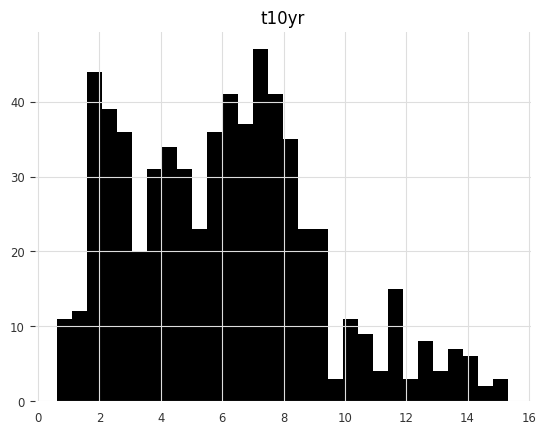

In [5]:
# multiplicative vs. additive 
train.hist(bins=30)

In [6]:
yt_i = train.t10yr[1:]
yt_i1 = train.t10yr.shift().dropna()
seas = np.log(yt_i1 / yt_i)

<Axes: >

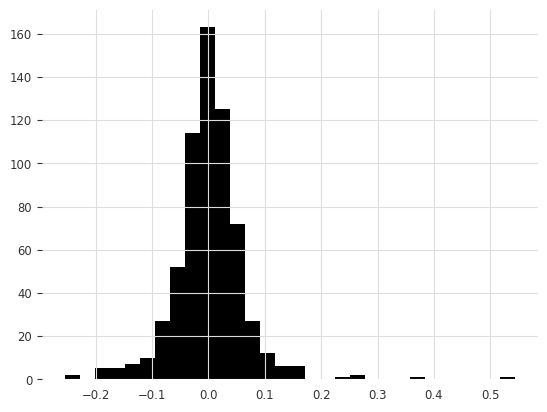

In [7]:
seas.hist(bins=30)

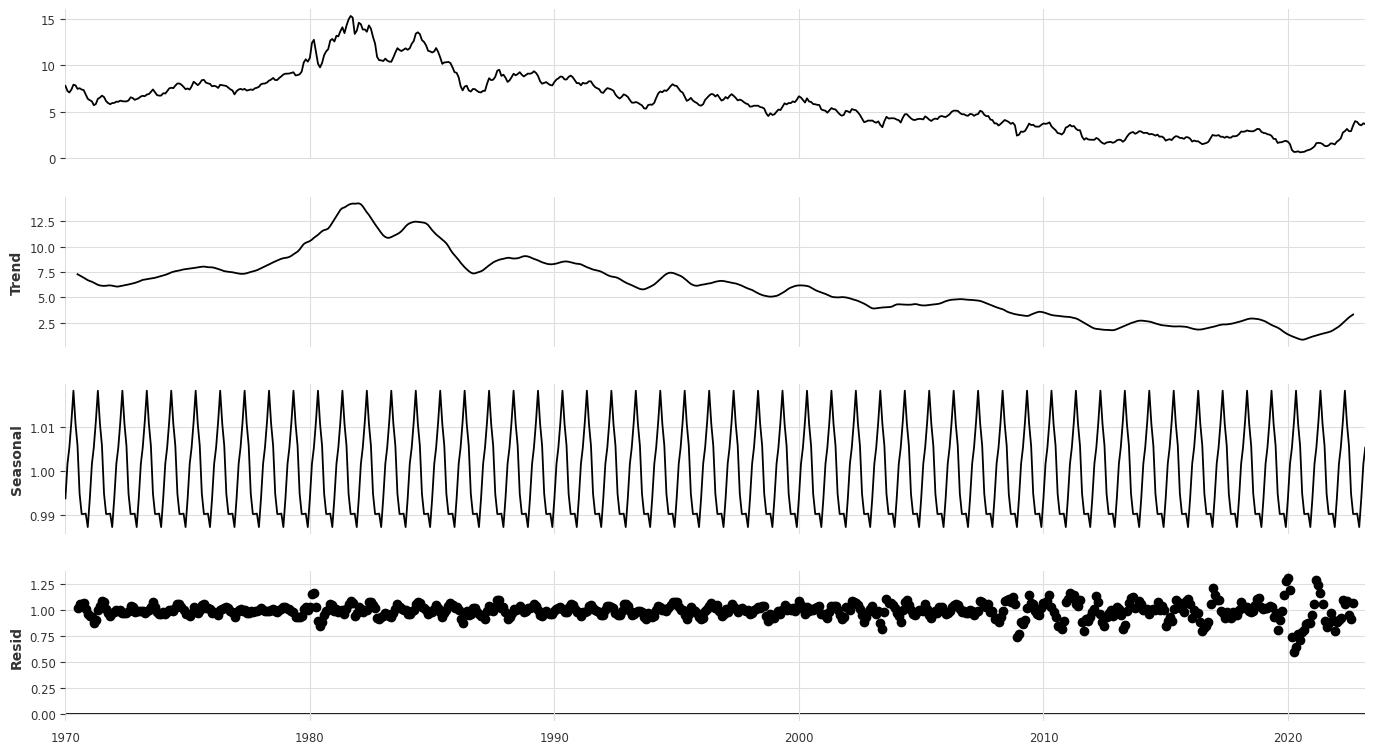

In [8]:
res = seasonal_decompose(train, model='multiplicative')
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)

In [9]:
ma_window = 12
seasonal_periods = 12

# Outlier Detection & Treatment

In [10]:
res_df = pd.DataFrame(columns=["# of Outliers", "% of Outliers"])
ts = np.array(train[['t10yr']])
outlier_mask = detect_outlier_iqr(ts, 2)

# store outlier information 
res_df.loc[:, "# of Outliers"] = outlier_mask.sum()
res_df.loc[:, "% of Outliers"] = outlier_mask.sum()/len(ts)*100
print(f"# of Outliers: {outlier_mask.sum()} | % of Outliers: {outlier_mask.sum()/len(ts)*100:.2f}%")

# of Outliers: 0 | % of Outliers: 0.00%


# Baseline Modeling 

In [21]:
# dataframes for evaluation 
pred_df = pd.concat([train, test])
metric_record = []

# univariates for baseline 
ts_train = TimeSeries.from_series(train)
ts_test = TimeSeries.from_series(test)

### Naive 

Time Elapsed: 0 microseconds


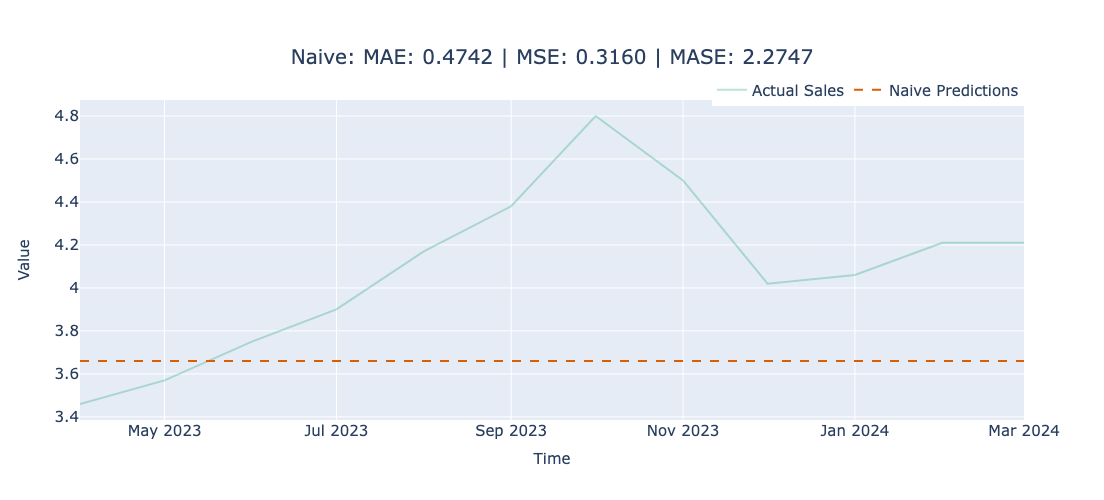

In [22]:
name = "Naive"
naive_model = NaiveSeasonal(K=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_test, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "naive_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["naive_predictions"], forecast_display_names=['Naive Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
fig.show()

### Moving Average 

Time Elapsed: 0 microseconds


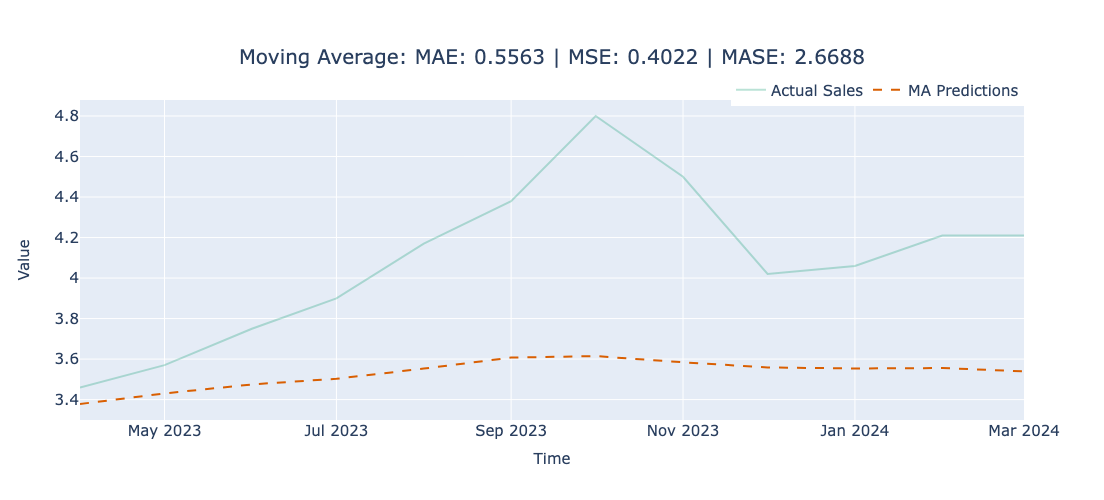

In [23]:
name = "Moving Average Forecast"
naive_model = NaiveMovingAverage(window=ma_window)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_test, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "moving_average_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["moving_average_predictions"], forecast_display_names=['MA Predictions'])
fig = format_plot(fig, title=f"Moving Average: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
fig.show()

### Seasonal Naive 

Time Elapsed: 0 microseconds


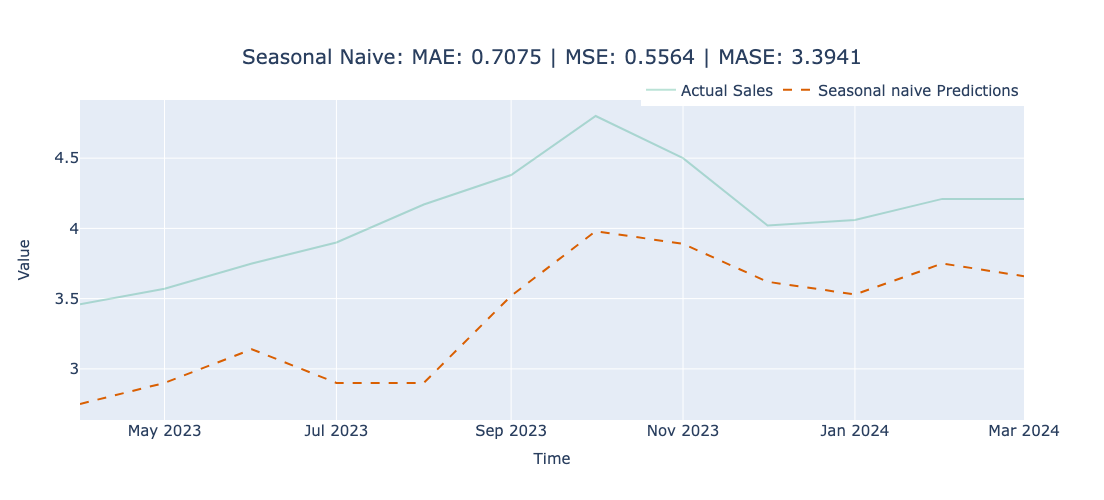

In [24]:
name = "Seasonal Naive Forecast"
naive_model = NaiveSeasonal(K=seasonal_periods)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_test, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "snaive_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["snaive_predictions"], forecast_display_names=['Seasonal naive Predictions'])
fig = format_plot(fig, title=f"Seasonal Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
fig.show()

### Exponential Smoothing

Time Elapsed: 0 microseconds


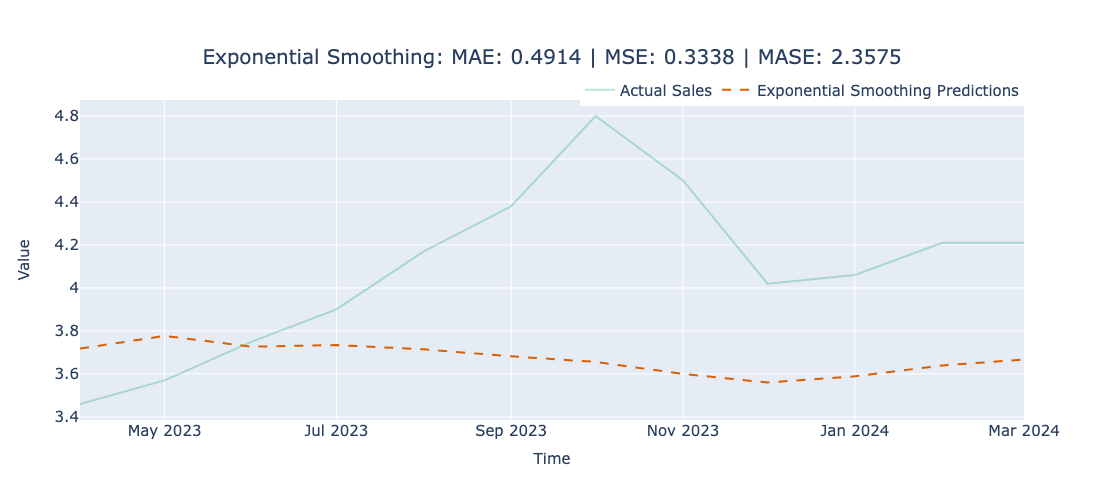

In [25]:
name = "Exponential Smoothing"
# Suppress FutureWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    ets_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=True, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=seasonal_periods, random_state=2)
    with LogTime() as timer:
        y_pred, metrics = eval_model(ets_model, ts_train, ts_test, name=name)
    metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "ets_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["ets_predictions"], forecast_display_names=['Exponential Smoothing Predictions'])
fig = format_plot(fig, title=f"Exponential Smoothing: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
fig.show()

### ARIMA

Time Elapsed: 2 seconds


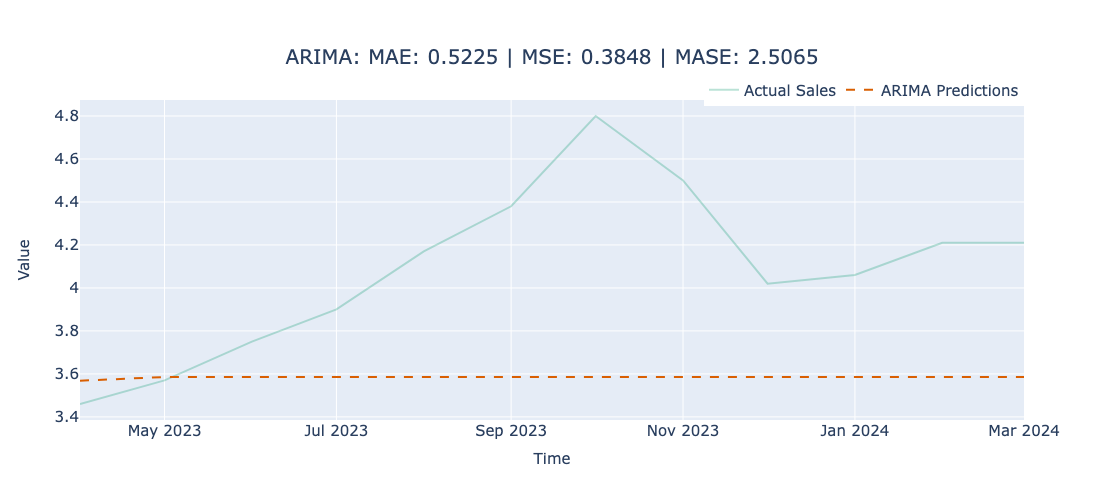

In [26]:
name = "ARIMA"
arima_model = AutoARIMA(max_p=5, max_q=3, seasonal=False)
with LogTime() as timer:
    y_pred, metrics = eval_model(arima_model, ts_train, ts_test,  name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "arima_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["arima_predictions"], forecast_display_names=['ARIMA Predictions'])
fig = format_plot(fig, title=f"ARIMA: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
fig.show()

### Theta 

Time Elapsed: 0 microseconds


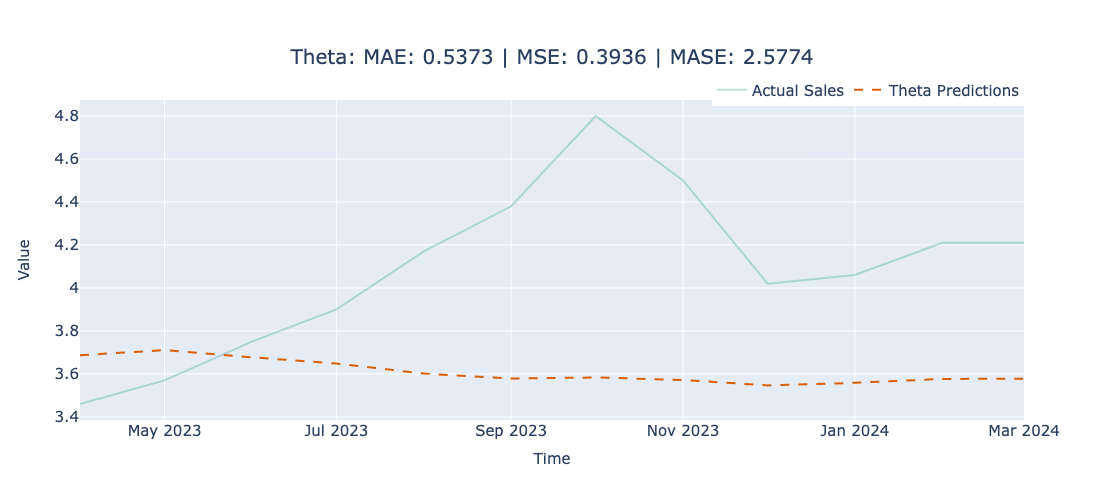

In [27]:
name = "Theta"
theta_model = Theta(theta=2, seasonality_period=seasonal_periods, season_mode=SeasonalityMode.MULTIPLICATIVE)
with LogTime() as timer:
    y_pred, metrics = eval_model(theta_model, ts_train, ts_test, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "theta_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["theta_predictions"], forecast_display_names=['Theta Predictions'])
fig = format_plot(fig, title=f"Theta: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
fig.show()

### FFT

Time Elapsed: 0 microseconds


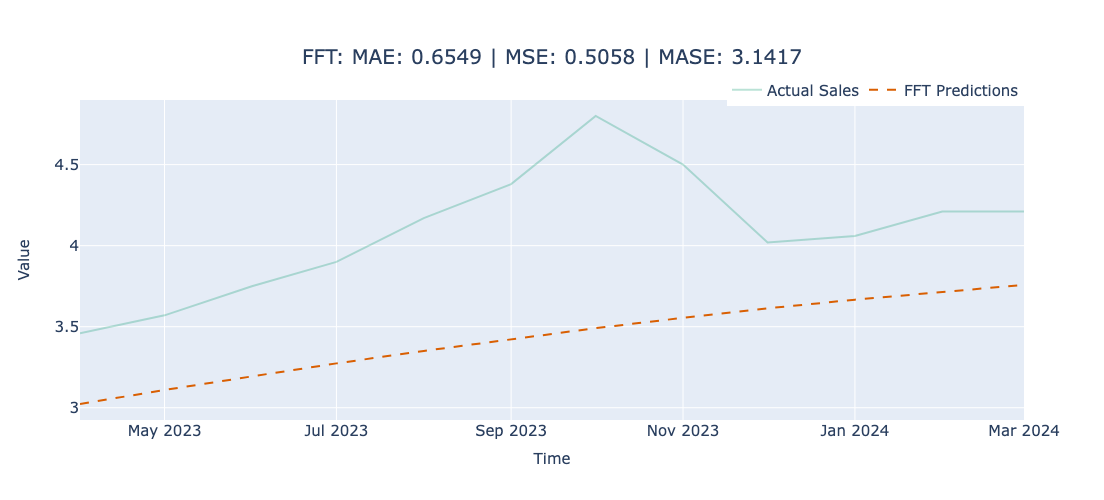

In [28]:
name = "FFT"
fft_model = FFT(nr_freqs_to_keep=seasonal_periods, trend="poly", trend_poly_degree=3)
with LogTime() as timer:
    y_pred, metrics = eval_model(fft_model, ts_train, ts_test, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "fft_predictions")
pred_df = pred_df.join(y_pred)

fig = plot_forecast(pred_df, forecast_columns=["fft_predictions"], forecast_display_names=['FFT Predictions'])
fig = format_plot(fig, title=f"FFT: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}")
fig.show()

### Comparison

In [29]:
metric_df = pd.DataFrame(metric_record)
metric_styled = metric_df.style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "MASE": "{:.3f}"}).highlight_min(color='lightgreen', subset=["MAE","MSE","MASE","Time Elapsed"])

display(metric_styled)

,Algorithm,MAE,MSE,MASE,Time Elapsed
0,Naive,0.474,0.316,2.275,0.005750
1,Moving Average Forecast,0.556,0.402,2.669,0.012431
2,Seasonal Naive Forecast,0.707,0.556,3.394,0.008018
3,Exponential Smoothing,0.491,0.334,2.358,0.190086
4,ARIMA,0.522,0.385,2.507,2.331479
5,Theta,0.537,0.394,2.577,0.034014
6,FFT,0.655,0.506,3.142,0.023738


# Export Baselines to Table

In [30]:
metric_df.to_csv('../data/baselines/univariate_baseline_results.csv', encoding='utf-8', index=False)